# Домашнее задание №3

# Задание 1
Разработать программу, принимающую на вход изображение из категории Imagenet своего варианта и
выдающее название категории изображенного объекта и вероятность соответствия его этой категории.

In [508]:
# Номер варианта
group, number = input("Input group and list number: ").split()
cls_number = int(group[-1]) * 20 + int(number) * 10
print("Class number:", cls_number)

Class number: 160


In [509]:
import os
import pickle

import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet18, ResNet18_Weights

In [510]:
def load_databatch(data_folder, file_name, img_size=64):
    data_file = os.path.join(data_folder, file_name)
    with open(data_file, 'rb') as f:
        d = pickle.load(f)

    X = d['data']
    y = d['labels']

    X = X.reshape(-1, 3, img_size, img_size)
    y = [i-1 for i in y]

    return [X, y]

In [511]:
data_folder = "Imagenet64_val"
file_name = "val_data"

X, y = load_databatch(data_folder, file_name)
print("Shape of X:", X.shape)
print("Length of y:", len(y))

Shape of X: (50000, 3, 64, 64)
Length of y: 50000


In [512]:
cls_indices = [i for i in range(len(y)) if y[i] == cls_number]
X_test = X[cls_indices]
y_test = [y[i] for i in cls_indices]
print("Shape of X_test:", X_test.shape)
print("Length of y_test:", len(y_test))

Shape of X_test: (50, 3, 64, 64)
Length of y_test: 50


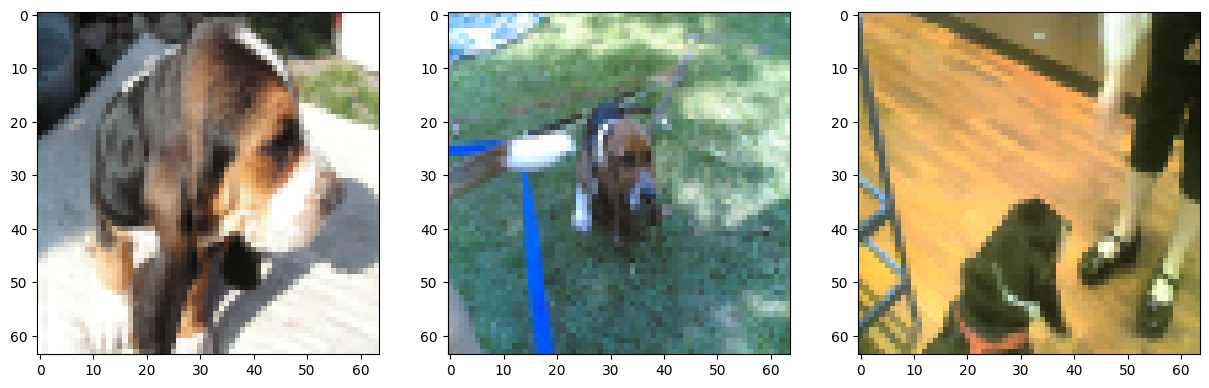

In [513]:
im_number = 3
fig, axes = plt.subplots(1, im_number)
fig.set_size_inches(5 * im_number, 5)
for i in range(im_number):
    axes[i].imshow((X_test[i]).transpose(1, 2, 0))

In [514]:
with open("Imagenet_classes.txt", 'r') as f:
    classes = [label[1:-1] for id, label in [line.split(',') for line in f]]
classes[:10]

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

In [515]:
def predict_class(model, preprocess, imgs):
    batch = preprocess(imgs)
    prediction = model(batch).softmax(dim=1)
    class_id = prediction.argmax(dim=1)
    return [class_id, prediction]

In [516]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
model = resnet18(weights=weights).eval()

test_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_test),
    torch.tensor(y_test)
    ), batch_size=8, num_workers=8)

pred_dict = {'label': [], 'confidence': []}

with torch.no_grad():
    for batch in test_dataloader:
        imgs, labels = batch
        pred_cls, pred_softmax = predict_class(model, preprocess, imgs)
        pred_dict['label'].extend([classes[i] for i in pred_cls])
        pred_dict['confidence'].extend([pred_softmax[i, pred_cls[i]].item() for i in range(pred_softmax.shape[0])])

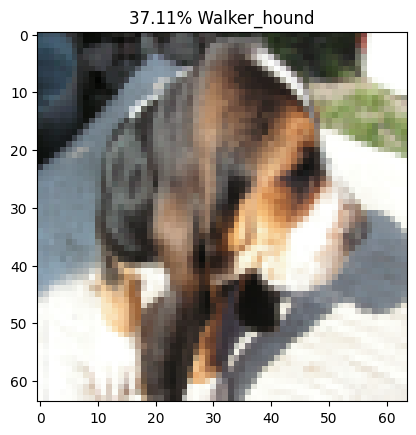

In [533]:
id = 0
plt.title(f"{pred_dict['confidence'][id] * 100:.2f}% {pred_dict['label'][id]}")
plt.imshow(X_test[id].transpose(1, 2, 0).astype(np.uint8))

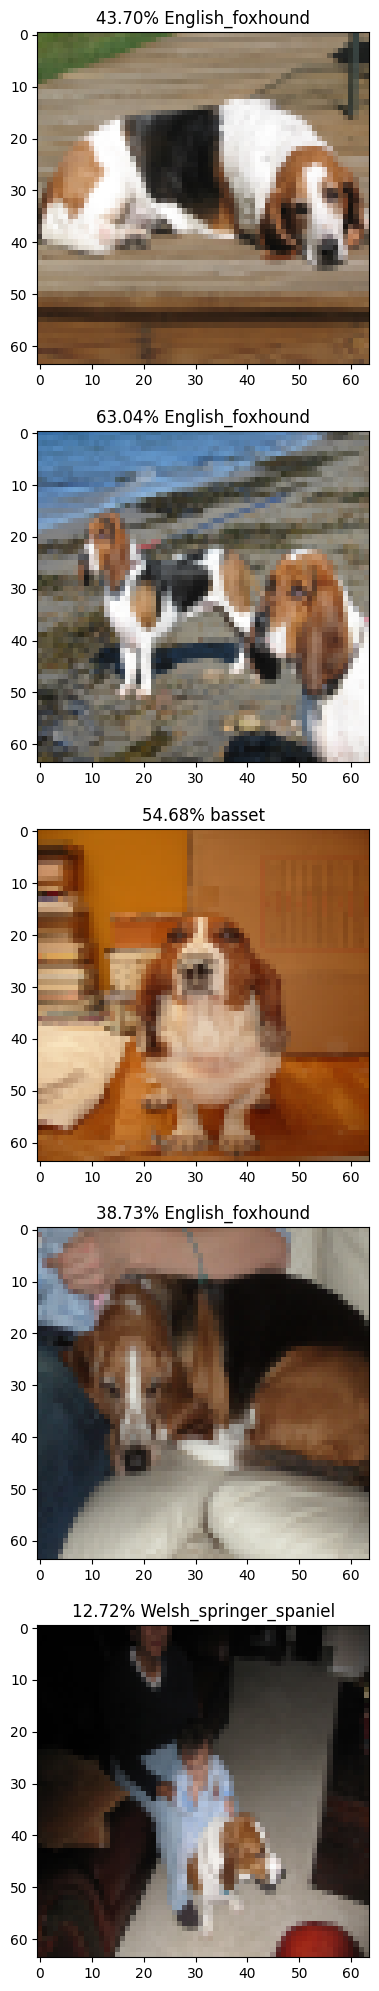

In [536]:
im_number = 5
tick = 8
fig, axes = plt.subplots(im_number)
fig.set_size_inches(5, 5 * im_number)
for i in range(im_number):
    axes[i].set_title(f"{pred_dict['confidence'][10 + i * tick] * 100:.2f}% {pred_dict['label'][10 + i * tick]}")
    axes[i].imshow((X_test[10 + i * tick]).transpose(1, 2, 0))